In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df_desc = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='descriptions')
df_factors = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='factors').set_index('Date')
df_portfolios = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name='portfolios (total returns)').set_index('Date')

In [3]:
# 2
df_factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031


In [4]:
# 2.1
import pandas as pd

def calculate_univariate_performance_statistics(df, annualization_factor=1, quantile=0.05, periods=None):
    if periods is None:
        periods = [(df.index.min(), df.index.max())]
    
    summary_list = []

    for period in periods:
        start_date, end_date = period
        period_df = df.loc[start_date:end_date]
        
        summary_df = pd.DataFrame(index=period_df.columns)
        summary_df['Mean'] = period_df.mean() * annualization_factor
        summary_df['Volatility'] = period_df.std() * (annualization_factor ** 0.5)
        summary_df['Sharpe_ratio'] = summary_df['Mean'] / summary_df['Volatility']
        summary_df[f'VaR({quantile})'] = period_df.quantile(quantile, axis=0)
        
        start_year = pd.to_datetime(start_date).year
        end_year = pd.to_datetime(end_date).year
        summary_df['Period'] = f"{start_year}-{end_year}"
        
        summary_df = summary_df.reset_index().rename(columns={'index': 'Factor'}).set_index(['Period', 'Factor'])
        summary_list.append(summary_df)
    
    summary = pd.concat(summary_list)
    return summary



summary_statistics = calculate_univariate_performance_statistics(df_factors.drop(columns=['RF']), 12)
# print(tabulate(summary_statistics, headers=summary_statistics.columns, tablefmt="heavy_grid"))
summary_statistics

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                               
1926-2024 Mkt-RF  0.082236     0.18471      0.445216  -0.079310
          SMB     0.021225     0.11004      0.192886  -0.042205
          HML     0.041237     0.12357      0.333713  -0.042100

In [5]:
periods = [(df_factors.index.min(), '1980-12-31'), ('1981-01-01', '2001-12-31'), ('2002-01-01', df_factors.index.max())]
summary_statistics = calculate_univariate_performance_statistics(df_factors.drop(columns=['RF']), 12, periods=periods)
summary_statistics

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                               
1926-1980 Mkt-RF  0.081138    0.205050      0.395696  -0.083985
          SMB     0.033985    0.114568      0.296638  -0.043400
          HML     0.049479    0.133825      0.369727  -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847  -0.064545
          SMB    -0.000862    0.118346     -0.007283  -0.046515
          HML     0.063776    0.111183      0.573612  -0.041790
2002-2024 Mkt-RF  0.089488    0.154644      0.578674  -0.078735
          SMB     0.011007    0.088944      0.123757  -0.039070
          HML     0.000538    0.107348      0.005014  -0.041245

#### 2.2
1. The Market factor has a consistent positive premium across all periods.
This could indicate enduring market excess returns.
SMB (Size) and HML (Value) factors show mixed performance, with SMB even showing a slight negative premium in 1981-2001.
This could indicate no universal premium for these factors.

2. Yes, SMB's premium declines significantly after 1980 and even turns negative in the 1981-2001 period.
This could indicate reduced benefit from small-cap exposure post-1980.

3. Yes, HML's premium remains positive but less impactful in the 1990s, showing a marginal decline.
This could indicate reduced investor preference for value stocks during this time.

4. Post-2002, Market factor shows a strong premium, but HML’s near-zero premium.
This could indicate minimal returns from value investing, reflecting shifting market dynamics.

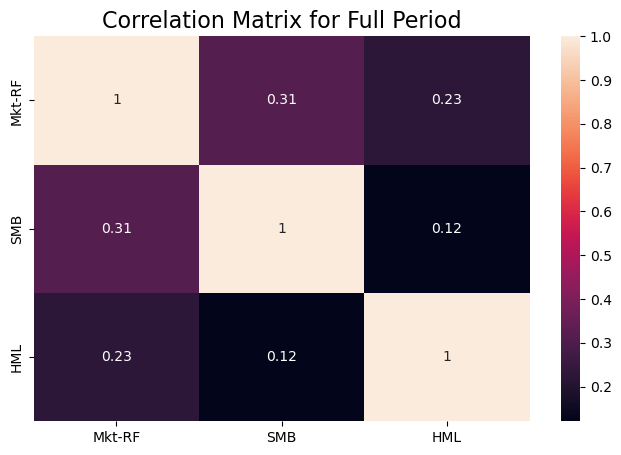

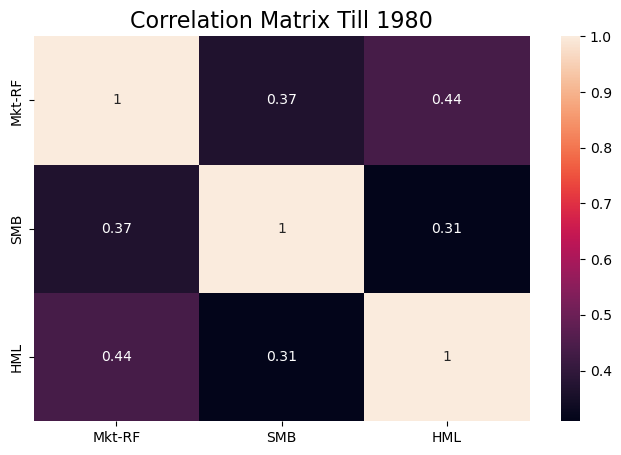

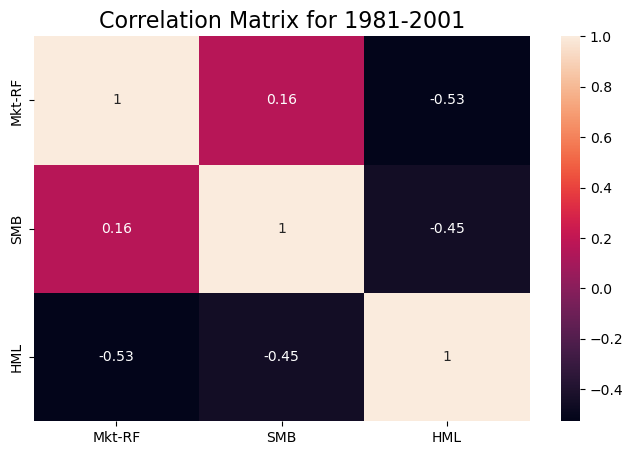

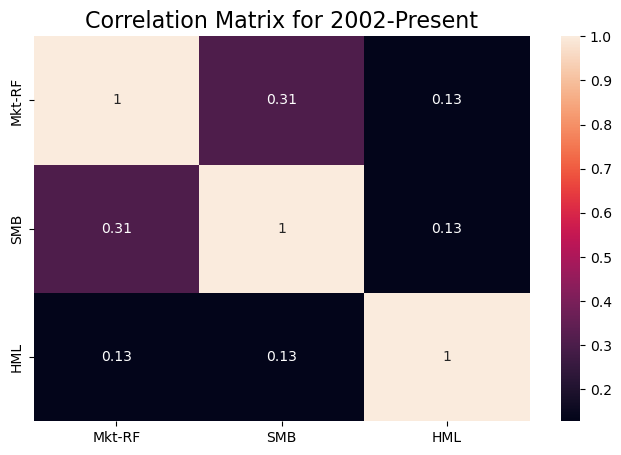

In [6]:
# 2.3
def plot_correlation_matrix(df, title=None, max_min=False):
    fig, ax = plt.subplots(figsize=(8, 5))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, 
                xticklabels=correlation_matrix.columns,
                yticklabels=correlation_matrix.columns, annot=True, ax=ax)
    if title:
        ax.set_title(title, fontsize=16)

    if max_min:
        corrs = correlation_matrix.unstack().sort_values().to_frame('Corr')
        corrs = corrs[corrs['Corr'] != 1]
        corrs_max = corrs.index[-1]
        corrs_min = corrs.index[0]
        print(f'Max Correlation pair is {corrs_max}')
        print(f'Min Correlation pair is {corrs_min}')

plot_correlation_matrix(df_factors.drop(columns=['RF']), title="Correlation Matrix for Full Period")
plot_correlation_matrix(df_factors.drop(columns=['RF']).loc[:'1980-12-31'], title="Correlation Matrix Till 1980")
plot_correlation_matrix(df_factors.drop(columns=['RF']).loc['1981-01-01':'2001-12-31'], title="Correlation Matrix for 1981-2001")
plot_correlation_matrix(df_factors.drop(columns=['RF']).loc['2002-01-01':], title="Correlation Matrix for 2002-Present")

1. Yes, The construction method effectively keeps correlations low, particularly evident in the negative or near-zero correlations between the Market (Mkt-RF), Size (SMB), and Value (HML) factors across all periods.
2. Yes, There are slight variations in correlation magnitudes across subsamples, the method generally succeeds in maintaining low correlations, supporting the robustness of factor independence over time.

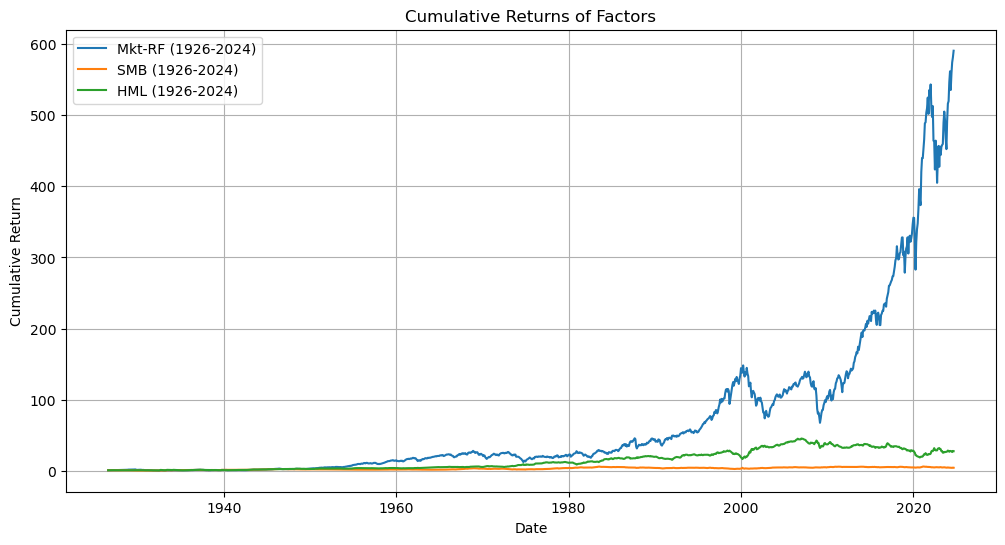

In [7]:
# 2.4
def plot_cumulative_returns(df, period=None, title="Cumulative Returns of Factors"):
    if period is None:
        period = (df.index.min(), df.index.max())
    
    start_date, end_date = pd.to_datetime(period[0]), pd.to_datetime(period[1])
    sub_df = df.loc[start_date:end_date]
    cumulative_returns = (1 + sub_df).cumprod()
    
    plt.figure(figsize=(12, 6))
    
    for column in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=f"{column} ({start_date.year}-{end_date.year})")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_returns(df_factors[['Mkt-RF', 'SMB', 'HML']])

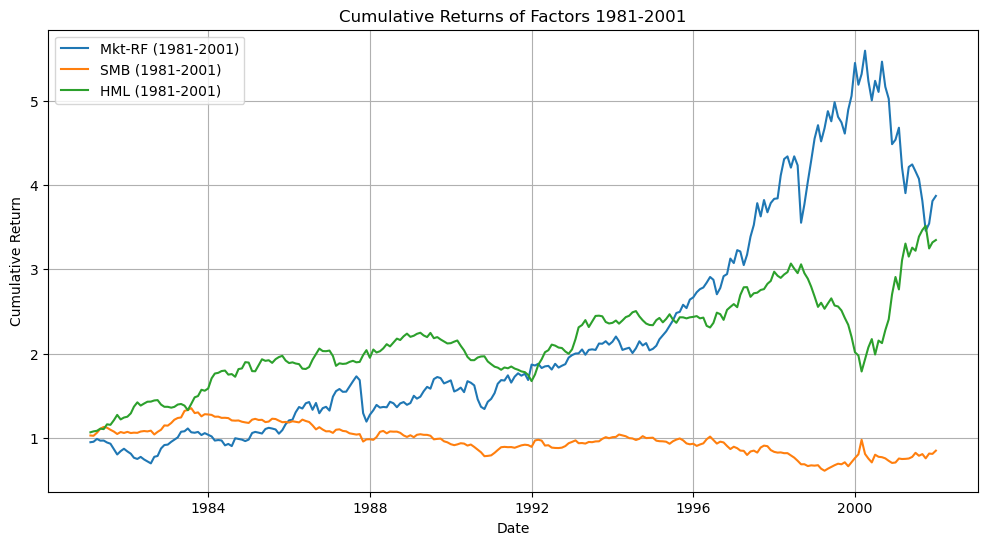

In [8]:
plot_cumulative_returns(
    df_factors[['Mkt-RF', 'SMB', 'HML']],
    title="Cumulative Returns of Factors 1981-2001",
    period=('1981-01-01','2001-12-31')
)

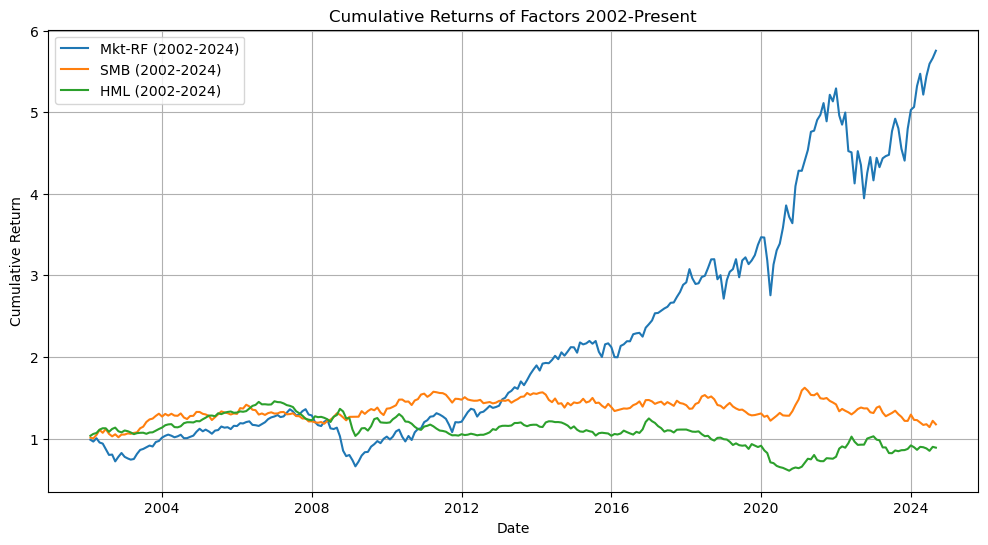

In [9]:
plot_cumulative_returns(
    df_factors[['Mkt-RF', 'SMB', 'HML']],
    title="Cumulative Returns of Factors 2002-Present",
    period=('2002-01-01', df_factors.index.max())
)

#### 2.5
1. The Market Risk Factor shines in both sub-samples but dips sharply with the tech bubble burst in 2001, allowing the Value Factor to post a premium amid depressed stock prices. The Size Factor, however, lags with near-zero or negative returns in 1981-2001.
2. Post-2002, the Market Factor recovers strongly, outpacing Size and Value, which post modest gains. Value sees declining premiums as stocks trade farther from fundamentals, though it still offers diversification.
3. Factor Rotation might be more effective going forward. The Size Factor seems outdated and correlated with the Market, while new factors like volatility, liquidity, and momentum could help DFA generate alpha in line with efficient market beliefs.

In [10]:
# 3
df_excess_portfolios = df_portfolios.loc['1981-01-01':].sub(df_factors['RF'].loc['1981-01-01':], axis=0)
df_excess_portfolios

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.054941,-0.014888,0.009909,0.005911,0.021085,-0.059733,-0.010738,-0.012684,0.007626,0.020623,...,-0.077022,-0.044926,-0.012942,-0.005534,0.003924,-0.071746,-0.083592,-0.074265,-0.010037,0.009464
1981-02-28,-0.044745,-0.010535,0.001444,0.009240,0.014398,-0.014473,0.005102,0.017420,0.024361,0.027939,...,0.002600,0.014707,0.034695,0.002673,0.027240,0.021950,0.009415,-0.016450,0.020446,-0.016853
1981-03-31,0.060718,0.082395,0.073568,0.077655,0.061040,0.068082,0.071500,0.066319,0.066325,0.063175,...,0.080443,0.055672,0.073222,0.061934,0.064868,0.017353,0.019940,-0.008875,0.022230,0.069573
1981-04-30,0.018141,0.035914,0.024600,0.036523,0.044090,0.006012,0.024744,0.026586,0.026781,0.029442,...,-0.010849,-0.019081,-0.006016,-0.007801,0.006253,-0.038311,-0.053508,-0.038006,0.010439,-0.040374
1981-05-31,0.038153,0.037824,0.032399,0.013389,0.016837,0.050452,0.010304,0.016889,-0.008609,0.013558,...,0.023970,0.010245,0.007640,-0.000759,0.021978,0.004288,-0.032791,-0.031355,0.026669,-0.005979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.130128,-0.076561,-0.079804,-0.079124,-0.080168,-0.072984,-0.087440,-0.068110,-0.060808,-0.073370,...,-0.061889,-0.068962,-0.064723,-0.073261,-0.062037,-0.044696,0.007208,-0.049422,-0.054638,-0.059445
2024-05-31,0.067929,0.028121,0.044908,0.031166,0.043491,0.041575,0.027868,0.050656,0.044027,0.046318,...,0.021254,0.017390,0.019487,0.048526,0.031667,0.055412,0.037588,0.026122,0.036084,0.038259
2024-06-30,-0.047089,-0.027302,-0.060055,-0.020509,-0.029688,-0.023300,-0.024891,-0.024715,-0.019464,-0.032911,...,-0.010171,-0.021718,-0.026953,-0.020711,-0.031647,0.057072,0.006973,-0.000874,-0.020792,0.002003


In [11]:
# 3.1
portfolio_summary = calculate_univariate_performance_statistics(df_excess_portfolios, 12)
portfolio_summary

Mean  Volatility  Sharpe_ratio  VaR(0.05)
Period    Factor                                                   
1981-2024 SMALL LoBM  0.006671    0.273771      0.024366  -0.126059
          ME1 BM2     0.088689    0.236403      0.375163  -0.094747
          ME1 BM3     0.092006    0.201252      0.457170  -0.086227
          ME1 BM4     0.115998    0.194270      0.597099  -0.076972
          SMALL HiBM  0.127838    0.210037      0.608646  -0.088535
          ME2 BM1     0.058868    0.245156      0.240125  -0.104096
          ME2 BM2     0.100515    0.205528      0.489059  -0.085661
          ME2 BM3     0.105946    0.185777      0.570288  -0.078490
          ME2 BM4     0.108835    0.182098      0.597670  -0.076138
          ME2 BM5     0.115994    0.215616      0.537967  -0.096398
          ME3 BM1     0.070988    0.224828      0.315743  -0.099699
          ME3 BM2     0.107164    0.188551      0.568352  -0.078481
          ME3 BM3     0.092339    0.173044      0.533618  -0.073470
          ME3 BM4     0.108758    0.180873      0.601296  -0.071814
          ME3 BM5     0.123854    0.203351      0.609063  -0.084232
          ME4 BM1     0.092356    0.202820      0.455361  -0.083643
          ME4 BM2     0.095974    0.177871      0.539572  -0.072905
          ME4 BM3     0.092687    0.175281      0.528792  -0.075607
          ME4 BM4     0.101693    0.176070      0.577571  -0.069504
          ME4 BM5     0.108216    0.198794      0.544360  -0.083426
          BIG LoBM    0.093934    0.164046      0.572606  -0.075476
          ME5 BM2     0.085241    0.154047      0.553343  -0.065048
          ME5 BM3     0.082494    0.153112      0.538784  -0.070380
          ME5 BM4     0.070224    0.171588      0.409259  -0.075757
          BIG HiBM    0.099289    0.206770      0.480192  -0.094141

1. The variation in mean excess returns across portfolios can be explained by their volatility, as higher returns often align with higher volatility levels, reflecting a risk-return tradeoff.
2. However, differences in VaR(0.05) statistics suggest that some portfolios face higher downside risk, indicating that volatility alone does not fully explain the variations in excess returns.

In [12]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

def capm_analysis(df_portfolios, df_market, annualization=1):
    alphas, treynor_ratios, information_ratios, r_squared = [], [], [], []
    betas_dict = {factor: [] for factor in df_market.columns} 

    for col in df_portfolios.columns:
        y = df_portfolios[col]
        X = sm.add_constant(df_market)
        model = sm.OLS(y, X, missing='drop').fit()
        
        alpha = model.params['const'] * annualization
        
        for factor in df_market.columns:
            betas_dict[factor].append(model.params.get(factor, np.nan))
        
        mean_excess_return = y.mean()
        primary_beta = model.params[df_market.columns[0]]
        treynor_ratio = mean_excess_return * annualization / primary_beta if primary_beta != 0 else np.nan

        expected_return = alpha + sum(model.params[factor] * df_market[factor].mean() for factor in df_market.columns)
        residual_std_dev = model.resid.std()
        
        information_ratio = model.params['const'] * (annualization)**0.5 / residual_std_dev if residual_std_dev != 0 else np.nan

        alphas.append(alpha)
        treynor_ratios.append(treynor_ratio)
        information_ratios.append(information_ratio)
        r_squared.append(model.rsquared)

    results_df = pd.DataFrame({
        'Alpha': alphas,
        'Treynor Ratio': treynor_ratios,
        'Information Ratio': information_ratios,
        'R-Squared': r_squared
    }, index=df_portfolios.columns)

    for factor, beta_values in betas_dict.items():
        results_df[f'Beta_{factor}'] = beta_values
    
    return results_df

results_df = capm_analysis(df_excess_portfolios, df_factors[['Mkt-RF']].loc['1981-01-01':], annualization=12)
results_df[['Alpha'] + [col for col in results_df.columns if col.startswith('Beta_')]]

,Alpha,Beta_Mkt-RF
SMALL LoBM,-0.106730,1.356365
ME1 BM2,-0.008774,1.165744
ME1 BM3,0.004620,1.045218
ME1 BM4,0.034696,0.972450
SMALL HiBM,0.044652,0.994979
ME2 BM1,-0.053049,1.338627
ME2 BM2,0.005631,1.134902
ME2 BM3,0.019949,1.028607
ME2 BM4,0.027344,0.974696
ME2 BM5,0.022822,1.114415


In [13]:
# 3.2b 
mae = np.mean(np.abs(results_df['Alpha']))
print("\nMean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.022428026900773772


In [14]:
# 3.2c
results_df[[col for col in results_df.columns if col.startswith('Beta_')] + ['Treynor Ratio', 'Information Ratio']]

,Beta_Mkt-RF,Treynor Ratio,Information Ratio
SMALL LoBM,1.356365,0.004918,-0.613409
ME1 BM2,1.165744,0.076080,-0.057999
ME1 BM3,1.045218,0.088026,0.039081
ME1 BM4,0.972450,0.119285,0.285425
SMALL HiBM,0.994979,0.128483,0.315148
ME2 BM1,1.338627,0.043976,-0.411917
ME2 BM2,1.134902,0.088568,0.053775
ME2 BM3,1.028607,0.103000,0.212415
ME2 BM4,0.974696,0.111660,0.272232
ME2 BM5,1.114415,0.104085,0.178588


#### 3.2d
1. Treynor Ratios should be similar across portfolios, as CAPM implies that returns are proportional to beta, suggesting a uniform return per unit of systematic risk.
2. Alphas should be close to zero for all portfolios, as CAPM assumes that all expected excess returns are captured by the market factor.
3. Information Ratios should be close to zero, indicating no significant deviations from the CAPM-predicted returns, meaning no additional risk-adjusted returns are being achieved beyond what CAPM explains.

In [15]:
# 3.3
capm_analysis(
    df_excess_portfolios.loc['1981-01-01':].mean().to_frame('Portfolio Mean Excess Returns'), 
    results_df[[col for col in results_df.columns if col.startswith('Beta_')]],
    12
)

,Alpha,Treynor Ratio,Information Ratio,R-Squared,Beta_Beta_Mkt-RF
Portfolio Mean Excess Returns,0.208623,-10.4114,35.404667,0.300557,-0.009015


1. R-Squared: 0.300557
2. Intercept: 0.208623
3. Regression Coefficient: -0.009015

1. R-Squared should be close to 1, as CAPM posits that beta should fully explain the cross-sectional variation in mean returns, implying a high explanatory power of the model.
2. Intercept should be close to zero, as CAPM suggests that all expected returns are captured by the relationship with beta, leaving no additional constant return.
3. Regression Coefficient should be Positive and equal to the market risk premium, reflecting the reward for taking on systematic risk. A negative coefficient, as seen here, would contradict CAPM, as it implies a penalty rather than a premium for beta exposure.

#### 3.4
1. Low R-squared, higher alphas, and CAPM’s limited beta suggest other risk factors, like size and value, play a key role in explaining portfolio returns.
2. Adding Size and Value factors boosts R-squared, aligning with DFA’s belief in the additional premia offered by these factors beyond CAPM.

In [16]:
# 4.1
def calculate_tangency_weights(df_excess_returns, annualization_factor=12):
    mu = df_excess_returns.mean() * annualization_factor
    cov_matrix = df_excess_returns.cov() * annualization_factor
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    ones = np.ones(len(mu))
    scaling_factor = 1 / (ones.T @ inv_cov_matrix @ mu)
    tangency_weights = scaling_factor * (inv_cov_matrix @ mu)
    tangency_df = pd.DataFrame({
        'Asset': df_excess_returns.columns,
        'Weights': tangency_weights
    })
    net_benchmark = df_excess_returns @ tangency_weights
    net_benchmark_df = pd.DataFrame(index = df_excess_returns.index)
    net_benchmark_df['Tangency'] = net_benchmark
    return tangency_df, net_benchmark_df

tangency_weights, tangency_returns = calculate_tangency_weights(df_excess_portfolios, annualization_factor=12)
tangency_weights

,Asset,Weights
0,SMALL LoBM,-2.122527
1,ME1 BM2,0.714753
2,ME1 BM3,0.174133
3,ME1 BM4,1.149019
4,SMALL HiBM,0.948036
5,ME2 BM1,-0.386376
6,ME2 BM2,0.906110
7,ME2 BM3,0.176695
8,ME2 BM4,-0.214854
9,ME2 BM5,-0.813314


In [17]:
results_tangency_df = capm_analysis(df_excess_portfolios, tangency_returns.loc['1981-01-01':], annualization=12)
# results_tangency_df[['Alpha'] + [col for col in results_tangency_df.columns if col.startswith('Beta_')]]

In [18]:
capm_analysis(
    df_excess_portfolios.loc['1981-01-01':].mean().to_frame('Portfolio Mean Excess Returns'), 
    results_tangency_df[[col for col in results_tangency_df.columns if col.startswith('Beta_')]],
    12
)

,Alpha,Treynor Ratio,Information Ratio,R-Squared,Beta_Beta_Tangency
Portfolio Mean Excess Returns,5.945900e-16,2.940675,6.859416,1.0,0.031919


In [19]:
# 4.3
df_factors_excess = df_factors.drop(columns=['RF'])
results_multi_df = capm_analysis(df_excess_portfolios, df_factors_excess.loc['1981-01-01':], annualization=12)

In [20]:
capm_analysis(
    df_excess_portfolios.loc['1981-01-01':].mean().to_frame('Portfolio Mean Excess Returns'), 
    results_multi_df[[col for col in results_multi_df.columns if col.startswith('Beta_')]],
    12
)

,Alpha,Treynor Ratio,Information Ratio,R-Squared,Beta_Beta_Mkt-RF,Beta_Beta_SMB,Beta_Beta_HML
Portfolio Mean Excess Returns,0.186491,-11.24266,36.112277,0.462776,-0.008349,-0.000156,0.002927


In [21]:
# 4.3
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

def calculate_H_statistic(portfolio_excess_returns, market_excess_return, annualization_factor=12, df=25):
    T = portfolio_excess_returns.shape[0]

    SR = market_excess_return.mean() * annualization_factor / (market_excess_return.std() * np.sqrt(annualization_factor))
    alphas = []
    residuals = []

    for col in portfolio_excess_returns.columns:
        y = portfolio_excess_returns[col]
        X = sm.add_constant(market_excess_return)
        model = sm.OLS(y, X, missing='drop').fit()
        
        alphas.append(model.params['const'] * annualization_factor)  # Annualized alpha
        residuals.append(model.resid)

    alpha_vector = np.array(alphas)

    resid_matrix = np.column_stack(residuals)
    Sigma = np.cov(resid_matrix, rowvar=False)
    Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=portfolio_excess_returns.columns, columns=portfolio_excess_returns.columns)

    H_statistic = T * (1 + SR ** 2) ** (-1) * (alpha_vector @ Sigma_inv @ alpha_vector)

    p_value = 1 - stats.chi2.cdf(H_statistic, df=df)
    return H_statistic, p_value

H_statistic, p_value = calculate_H_statistic(
    df_excess_portfolios.loc['1981-01-01':], 
   df_factors[['Mkt-RF']].loc['1981-01-01':])

print(f"H-Statistic: {H_statistic}")
print(f"p-value: {p_value}")

H-Statistic: Mkt-RF    15560.101076
dtype: float64
p-value: [0.]


1. The H-test is stricter, as it captures the joint significance of all alphas, indicating a systematic CAPM failure rather than isolated anomalies.
2. A significant H implies that the market factor alone cannot span the efficient frontier, suggesting the need for additional factors to reach the tangency portfolio.